## Load Python packages

In [160]:
from glob import glob
from transformers import AutoModelForImageClassification
import torch
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import json
import os
import warnings
from copy import deepcopy
from datetime import datetime
from IPython.display import clear_output
from sklearn.model_selection import StratifiedKFold
from utils import CustomMatrixDataset,CustomMatrixDataset_augmentation
from Chowder import TorchTrainer, Chowder, auc2, slide_level_train_step, slide_level_val_step, get_cv_metrics
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, roc_auc_score
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from collections import Counter

In [ ]:
# useful functions

# get patient id from path
def get_patient_id_from_path(path):
    patient=path.split('\\')[-1].split('[')[0][:-5]
    return(str(patient))
    
# load and display images
def load_image(path):
    image=cv2.imread(path)
    return(image)

def show_image(image):
    fig,ax=plt.subplots()
    if image.shape[0] == 3:
        image=image.permute({1,2,0})
    ax.imshow(image)
    return(fig)

# Normalization: reduction to be in the range [0,1] by dividing by 255 and use ImageNet mean and std
def normalize_image(tensor,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]):
    if tensor.shape[0] != 3:
        tensor=tensor.permute(2,0,1)
    norm_tens=torch.div(tensor, 255.0) #norm between 0 and 1
    for k in range(3): #ImageNet norm
        norm_tens[k,:,:]=torch.sub(norm_tens[k,:,:],mean[k])
        norm_tens[k,:,:]=torch.div(norm_tens[k,:,:],std[k])
    return(norm_tens)

# tile encoder
# encoded tiles are saved at save_path if defined
def encode_patch(path, encoder, save_path=None):
    img=load_image(path)
    encoded_patchs=[]
    encoder=encoder.to(device)
    tensor=normalize_image(torch.from_numpy(img).to(device))
    tensor=tensor.unsqueeze(0) # Add a dimension to mimic a batch (but contains only one image)
    enc=encoder(tensor)[0][0].clone().detach()
        
    if save_path != None:
        os.makedirs(save_path, exist_ok=True)
        patch_name=path.split('\\')[-1].split('.')[0]
        torch.save(enc,save_path+'\\'+patch_name+'_enc.pt')
    return(enc)

# creation of a new dictionnary as the list of encoded tiles
def create_patient_encoded_dict(patient_dict, encoder, patch_tiling_infos=None, save_path=None, is_saved=None):
    if is_saved !=None:
        print('Loading patient dict')
        patient_encoded=torch.load(is_saved)
    else:
        patient_encoded={}
        progress_bar = tqdm.tqdm(total=np.sum([len(patient_dict[patient]) for patient in list(patient_dict.keys())]), position=0,
                                 desc="Processing")
        for i,patient in enumerate(list(patient_dict.keys())):
            progress_bar.set_description("Processing patient {}/{}".format(i+1,len(patient_dict)))
            tile_list=patient_dict[patient]
            patient_encoded[patient]=[]
            
            for tile_path in tile_list:
                patient_encoded[patient].append(encode_patch(tile_path,encoder,save_path=save_path))
                                
            progress_bar.update(1)
        
    return(patient_encoded)

from torch.utils.data import Dataset


# function that gets tile coordinates so that it can be added to groovy QuPath script
def new_feature(path, res, clss):
    if clss=='top':
        color=[0, 0, 255]
    else:
        color=[128, 0, 0]

    x=int(path.split('x=')[-1].split(',')[0])
    y=int(path.split('y=')[-1].split(',')[0])
    if res=='20X':
        sq_size=224*2
    elif res=='10X':
        sq_size=224*4
    elif res=="5X":
        sq_size=224*8
    square_coords=[[[x,y],[x+sq_size,y],[x+sq_size,y+sq_size],[x,y+sq_size],[x,y]]]
    f={"type":"Feature","geometry":{"type":"Polygon","coordinates":square_coords},
       "properties":{"objectType":"annotation","classification":{"name":clss,"color":color}}}
    return f

### Import tiles

In [163]:
# information related to tiles
res=""
path_to_images="to be changed"
patch_list=glob(path_to_images+'\\*')

# display a tile as an example
path=patch_list[20]
img=load_image(path)
fig=show_image(img)

In [166]:
# create a dictionnary that stores every tile available for each patient
whole_patient_dict={}
for patch in patch_list: #Look through all paths
    patient=get_patient_id_from_path(patch)
    if patient not in whole_patient_dict.keys(): #If it is the first time the patient pops up, create a new key that will be its list
        whole_patient_dict[patient]=[]
    whole_patient_dict[patient].append(patch)

## Encoding tiles

In [18]:
# load pretrained model
encoder = AutoModelForImageClassification.from_pretrained(
    "owkin/phikon",
    ignore_mismatched_sizes=False,
)
# Remove last layer 
encoder.classifier=torch.nn.Sequential()

# select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model in evaluation mode to prvent it from being trained
encoder=encoder.eval()

# define labels for classification 
label_file_path = "to be changed"
label_file=label_file_path
labels=pd.read_csv(label_file, delimiter=";")
labels['patient_id'] = labels['patient_id'].astype(str)
nb_classes=len(set(list(labels['label'])))

# add ID and FOLD columns
labels=labels.sort_values('label').reset_index().drop(['index'],axis=1)
nb_0, nb_1=labels.groupby('label').count().values
list_0, list_1= [], []
for i in range(int(nb_0)):
    list_0.append(i%5)
for j in range(int(nb_1)):
    list_1.append(j%5)
new_col={'fold':list_0+list_1, 'ID':np.arange(len(labels))}
new_labels=pd.concat([labels,pd.DataFrame.from_dict(new_col)],axis=1)

# minimum number of tiles for a patient
len_list=[]
for patient in whole_patient_dict.keys():
    len_list.append(len(whole_patient_dict[patient]))
mini=min(len_list)

print('Your minimum number of patches is',mini)

# remove patients with less than nb_path tiles
nb_patch=mini-1
patient_dict={}
removed=0
for patient in whole_patient_dict.keys():
    if len(whole_patient_dict[patient])>nb_patch:
        patient_dict[patient]=whole_patient_dict[patient]
    else:
        removed+=1
print('You removed', removed, 'patients')

# loading encoded dict if already defined
patient_encoded=create_patient_encoded_dict(patient_dict, encoder, save_path=None, is_saved=f"D:\\02_TILES\\004_encoded\\{res}_patient_dict_shuffle.pt")

# define a CustomMatrixDataset
whole_ds=CustomMatrixDataset(patient_encoded, new_labels, nb_patch=mini, fixed=False

## Training

In [180]:
# definition of the loss function, the optimizer and metrics for the training
criterion = torch.nn.CrossEntropyLoss()  #Cross-Entropy Loss
optimizer = torch.optim.Adam              # Adam optimizer
metrics = {"auc": auc2}                    # AUC will be the tracking metric

# parameters for cross-validation
n_outer_cv = 5
n_inner_cv = 4
train_metrics, val_metrics = [], []
train_losses, val_losses = [], []
test_logits = []

# parameters for training
batch_size=64
num_epochs=100
learning_rate=1e-3
weight_decay=0.0
device=device
balanced=True

# initialization of a Chowder MIL
chowder = Chowder(
    in_features=768,                     # output dimension of Phikon
    out_features=nb_classes,             # dimension of predictions (a probability for class "1")
    n_top=5,                             # number of top scores in Chowder 
    n_bottom=5,                          # number of bottom scores in Chowder
    mlp_hidden=[200, 100],               # MLP hidden layers after the max-min layer
    mlp_activation=torch.nn.Sigmoid(),   # MLP activation
    bias=True                            # bias for first 1D convolution which computes scores
)
best_model_inner_cv={}


Finished cross-validation in 0:06:32.760947


In [ ]:
# training

cv_start_time = datetime.now()
for test_fold in range(n_outer_cv):
    best_model_inner_cv[test_fold]={}
    print(f"Running cross-validation #{test_fold+1}")
    # We stratify with respect to the training labels
    test_idx=list(new_labels[new_labels['fold']==test_fold]['ID'])
    test_set = torch.utils.data.Subset(whole_ds, test_idx)

    test_lab=[]
    for i in range(len(test_set)):
        test_lab.append(test_set[i][1])
    
    cv_splits=[]
    for j in range(n_inner_cv):
        val_fold=j if j<test_fold else j+1
        val_idx=list(new_labels[new_labels['fold']==val_fold]['ID'])
        train_idx=list(new_labels[(new_labels['fold']!=test_fold) & (new_labels['fold']!=val_fold)]['ID'])
        cv_splits.append((train_idx,val_idx))

    for i, (train_indices, val_indices) in enumerate(cv_splits):
        fold_start_time = datetime.now()
        trainer_2 = TorchTrainer(
            model=deepcopy(chowder),
            criterion=criterion,
            metrics=metrics,
            batch_size=batch_size,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            device=device,
            balanced=balanced,
            num_workers=0, 
            optimizer=deepcopy(optimizer),
            train_step=slide_level_train_step,
            val_step=slide_level_val_step,
            nb_classes=nb_classes
        )

        print(f"Running cross-validation on split #{i+1}")
        train_train_dataset = torch.utils.data.Subset(
            whole_ds, indices=train_indices
        )
        train_val_dataset = torch.utils.data.Subset(
            whole_ds, indices=val_indices
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            # Training step for the given number of epochs
            local_train_metrics, local_val_metrics, local_train_losses, local_val_losses = trainer_2.train(
                train_train_dataset, train_val_dataset
            )
            # Predictions on test (logits, sigmoid(logits) = probability)
            local_test_logits = trainer_2.predict(test_set)[1]

        train_metrics.append(local_train_metrics)
        val_metrics.append(local_val_metrics)
        train_losses.append(local_train_losses)
        val_losses.append(local_val_losses)
        test_logits.append(local_test_logits)
        fold_end_time = datetime.now()
        fold_running_time = fold_end_time - fold_start_time
        best_model_inner_cv[test_fold][i]=trainer_2.best_sd
        print("\n-----------------------------Finished in {}---------------------------------------\n".format(fold_running_time))
    clear_output()
cv_end_time = datetime.now()

cv_running_time = cv_end_time - cv_start_time
print("\nFinished cross-validation in {}".format(cv_running_time))

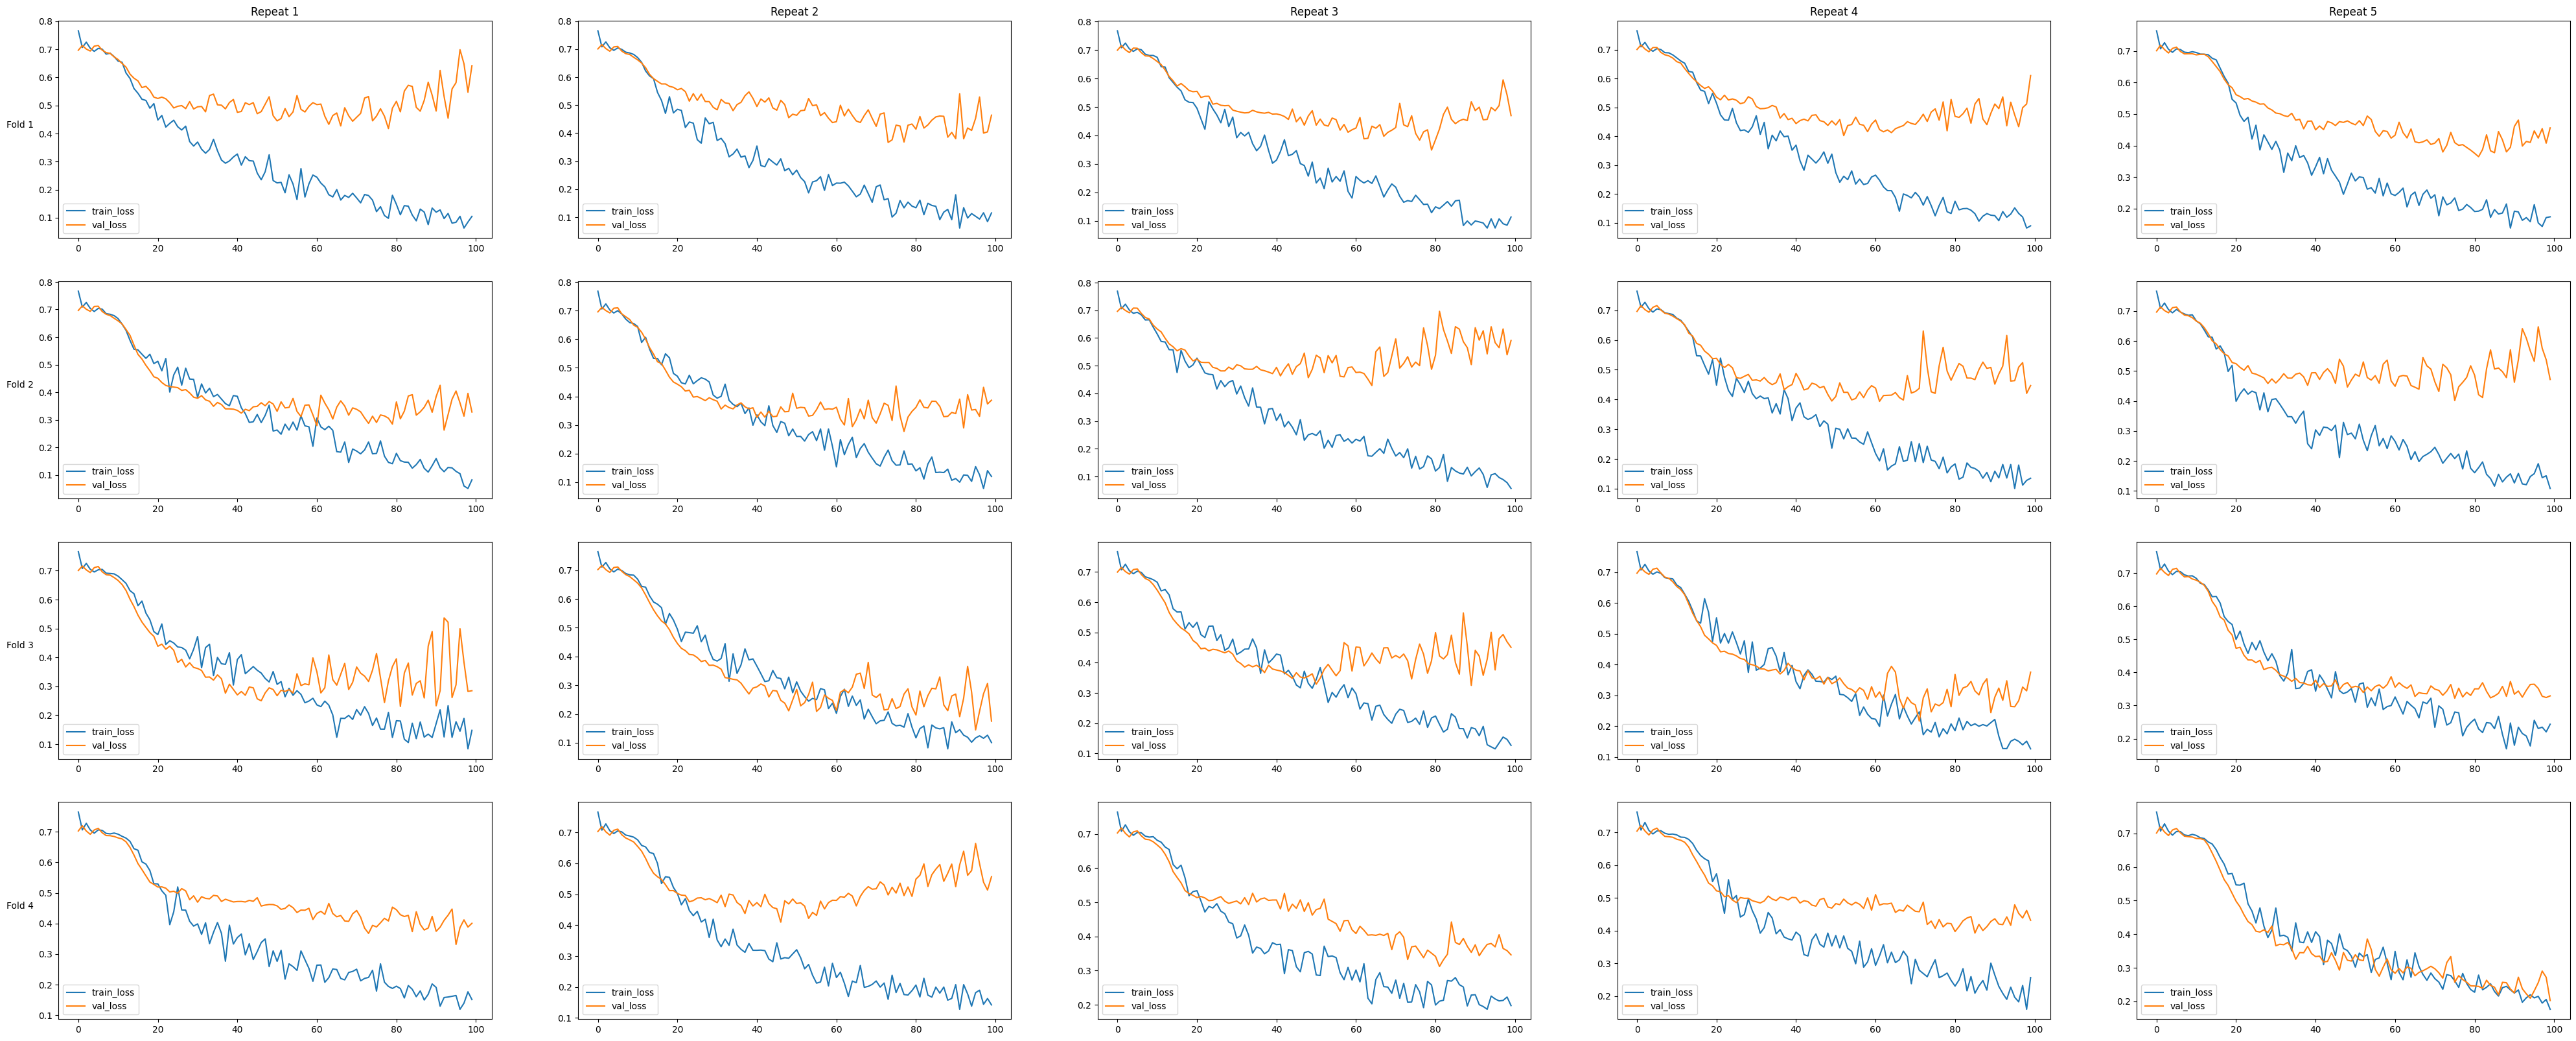

In [183]:
# plot losses
figure,axs=plt.subplots(ncols=n_outer_cv,nrows=n_inner_cv, figsize=(10*n_outer_cv,5*n_inner_cv))
X=np.arange(trainer_2.num_epochs)
for j in range(n_outer_cv):
    for i in range(n_inner_cv):
        if n_outer_cv==1:
            ax=axs[i]
        else:
            ax=axs[i,j]
        
        Y_train=train_losses[j*n_inner_cv+i]
        Y_val=val_losses[j*n_inner_cv+i]
        ax.plot(X,Y_train, label='train_loss')
        ax.plot(X,Y_val, label='val_loss')
        if i==0:
            ax.title.set_text('Repeat '+str(j+1))
        if j==0:
            ax.set_ylabel('Fold '+ str(i+1), rotation=0, labelpad=20)
        ax.legend(loc='lower left')
        fig.tight_layout()

## Model Evaluation

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


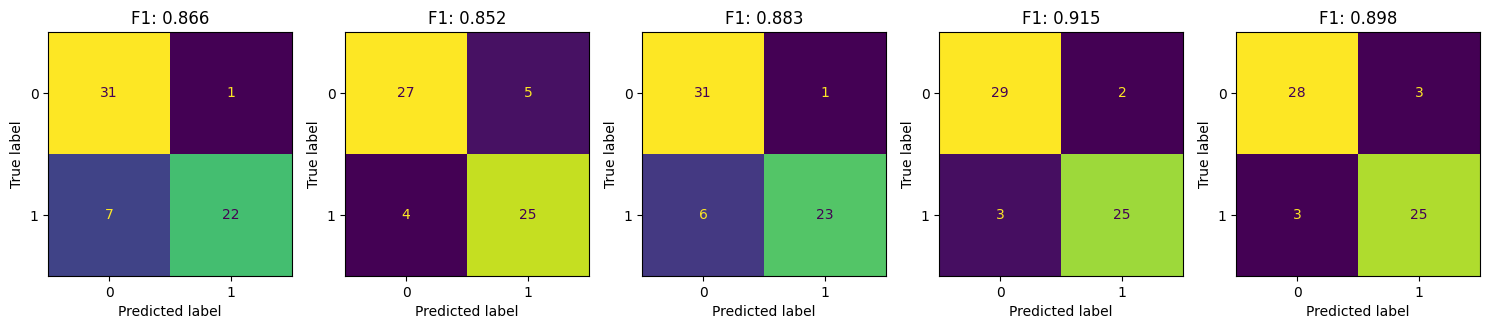

In [184]:
# subplots for confusion matrices
fig, axs_cm = plt.subplots(1, n_outer_cv, figsize=(15, 10))

# store true labels and predicted probabilities for ROC curve and Se Sp
roc_data = {'true_labels': [], 'probas': []}
sensitivity_scores = []
specificity_scores = []
auc_scores = []

best_model_outer_cv={}
for test_fold in tqdm.tqdm(range(n_outer_cv)):
    test_idx=list(new_labels[new_labels['fold']==test_fold]['ID'])
    test_set = torch.utils.data.Subset(whole_ds, test_idx)
    test_dl = DataLoader(test_set)
    
    best_f1=0
    
    for val_fold in range(n_inner_cv):
        model_test=deepcopy(trainer_2.model)
        model_test.load_state_dict(best_model_inner_cv[test_fold][val_fold])
        true_lab=[]
        logits=[]
        with torch.no_grad():
            model_test=model_test.eval()
            model_test=model_test.to(device)
            for batch in test_dl:
                matrix, lab = batch
                matrix = matrix.to(device)
                true_lab.append(lab)
                logits.append(model_test(matrix).squeeze(1))

            probas=torch.nn.functional.softmax(torch.stack(logits).squeeze(1), dim=1).to('cpu')
            preds=torch.argmax(probas,1)

            test_f1=f1_score(np.array(preds), np.array(torch.stack(true_lab)), average='macro')
            if test_f1 > best_f1:
                best_f1=test_f1
                best_model_outer_cv[test_fold]=(best_model_inner_cv[test_fold][val_fold], preds)

    # Concatenate all true labels and predictions
    true_lab = torch.cat(true_lab).numpy()  # Flatten to a 1D array
    preds = best_model_outer_cv[test_fold][1].numpy()

    if len(true_lab) == len(preds):  # Ensure lengths match before computing the confusion matrix
        # Compute confusion matrix
        test_cm = confusion_matrix(true_lab, preds)
        
        # Extract TP, TN, FP, FN from confusion matrix
        TN, FP, FN, TP = test_cm.ravel()

        # Compute Sensitivity (Recall) and Specificity
        sensitivity = TP / (TP + FN)  # True Positive Rate (Recall)
        specificity = TN / (TN + FP)  # True Negative Rate (Specificity)

        # Store Sensitivity and Specificity for this fold
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

        # Plot confusion matrix on the first row
        disp = ConfusionMatrixDisplay(test_cm)
        disp.plot(ax=axs_cm[test_fold], colorbar=False)
        axs_cm[test_fold].set_title(f'F1: {best_f1:.3f}')

        # Store data for ROC curve plotting later
        roc_data['true_labels'].append(true_lab)
        roc_data['probas'].append(probas.numpy())  # Store probabilities for AUC calculation

    else:
        print(f"Warning: True labels and predictions length mismatch for fold {test_fold}")

# Display the confusion matrices plot
plt.tight_layout()
plt.show()

#fig.savefig("confusion_matrices.png", dpi=300)  # Save the confusion matrix with 300 DPI to the working directory, default is desktop

In [185]:
# Print the results for Sensitivity and Specificity
print("\nSensitivity and Specificity for each fold:")
for i in range(n_outer_cv):
    print(f"Fold {i}: Sensitivity = {sensitivity_scores[i]:.3f}, Specificity = {specificity_scores[i]:.3f}")

# Calculate and print the mean and standard deviation of Sensitivity and Specificity
mean_sensitivity = np.mean(sensitivity_scores)
std_sensitivity = np.std(sensitivity_scores)
mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)

print(f"\nSummary on internal dataset:")
print(f"Mean Sensitivity: {mean_sensitivity:.3f} ± {std_sensitivity:.3f}")
print(f"Mean Specificity: {mean_specificity:.3f} ± {std_specificity:.3f}")

#calculate meand+-sd F1 Score
f1_scores = [0.869, 0.851, 0.951, 0.949, 0.815]
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 Score: {mean_f1:.3f} ± {std_f1:.3f}")


Sensitivity and Specificity for each fold:
Fold 0: Sensitivity = 0.759, Specificity = 0.969
Fold 1: Sensitivity = 0.862, Specificity = 0.844
Fold 2: Sensitivity = 0.793, Specificity = 0.969
Fold 3: Sensitivity = 0.893, Specificity = 0.935
Fold 4: Sensitivity = 0.893, Specificity = 0.903

Summary on internal dataset:
Mean Sensitivity: 0.840 ± 0.055
Mean Specificity: 0.924 ± 0.047
Mean F1 Score: 0.887 ± 0.054


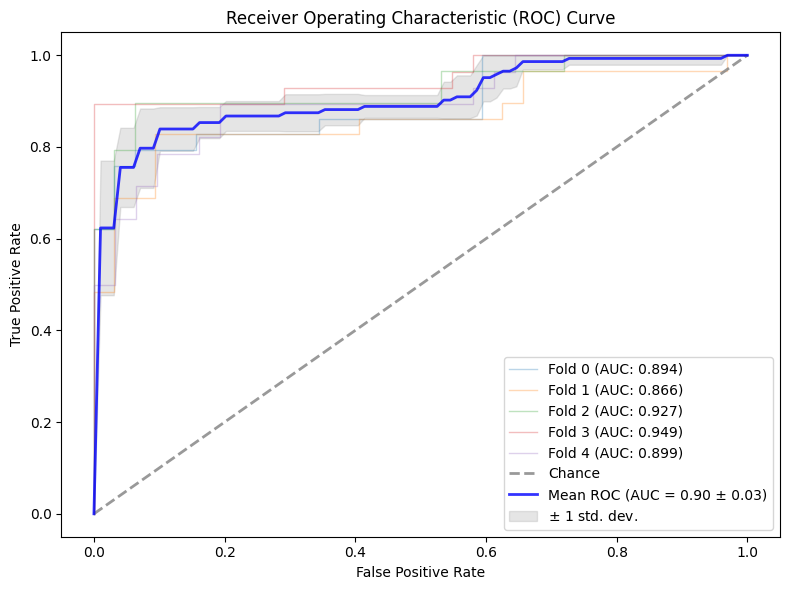

Mean AUC: 0.903 ± 0.028


In [186]:
# List to store AUC for each fold
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# Create a figure for all ROC curves on the same plot
fig, ax = plt.subplots(figsize=(8, 6))

# Loop over stored ROC data and plot all ROC curves on the same plot
for test_fold in range(n_outer_cv):
    true_labels = roc_data['true_labels'][test_fold]
    probas = roc_data['probas'][test_fold]
    
    # Calculate ROC curve for this fold
    fpr, tpr, _ = roc_curve(true_labels, probas[:, 1])  # Get ROC curve values for the positive class (class 1)
    
    # Interpolate the TPR (True Positive Rate) to a common set of FPR values (mean_fpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0  # Ensure the curve starts at (0,0)
    tprs.append(interp_tpr)
    
    # Calculate AUC for this fold and store it
    auc_score = roc_auc_score(true_labels, probas[:, 1])  # AUC for binary classification
    auc_scores.append(auc_score)
    
    # Use RocCurveDisplay to plot ROC curve for this fold
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score).plot(ax=ax, alpha=0.3, lw=1, label=f'Fold {test_fold} (AUC: {auc_score:.3f})')

# Plot the diagonal (chance level)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", label="Chance", alpha=0.8)

# Calculate the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)

# Calculate the mean AUC
mean_auc = auc(mean_fpr, mean_tpr)

# Calculate the standard deviation of the AUC
std_auc = np.std(auc_scores)

# Plot the mean ROC curve
ax.plot(mean_fpr, mean_tpr, color="b", label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)

# Calculate the standard deviation of the TPRs (True Positive Rates)
std_tpr = np.std(tprs, axis=0)

# Create shaded area for the std deviation
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

# Customize the plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic (ROC) Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.grid(False)

# Display the plot
plt.tight_layout()
plt.show()

# Print the mean and standard deviation of the AUC scores
print(f"Mean AUC: {mean_auc:.3f} ± {std_auc:.3f}")

#fig.savefig("roc_curves_all.png", dpi=300)  # Save the confusion matrix with 300 DPI to the working directory, default is desktop

## External validation dataset

In [187]:
# load external validation dataset
external_dataset_encoded_tiles_path = "to be changed"
external_dataset_label_path = "to be changed"
external_encoded=torch.load(external_dataset_encoded_tiles_path)
external_label=pd.read_csv(external_dataset_label_path, delimiter=';')
not_found=external_label[~external_label['patient_id'].isin(list(external_encoded.keys()))]
external_label=external_label[external_label['patient_id'].isin(list(external_encoded.keys()))]

external_label=external_label.sort_values('label').reset_index().drop(['index'],axis=1)
nb_0, nb_1=external_label.groupby('label').count().values
list_0, list_1= [], []
for i in range(int(nb_0)):
    list_0.append(i%5)
for j in range(int(nb_1)):
    list_1.append(j%5)
new_col={'fold':list_0+list_1, 'ID':np.arange(len(external_label))}
new_external_label=pd.concat([external_label,pd.DataFrame.from_dict(new_col)],axis=1)



fig, axs = plt.subplots(1, n_outer_cv, figsize=(15, 10))

# Prepare external dataset
external_ds = CustomMatrixDataset(external_encoded, new_external_label, nb_patch=20, fixed=False, all_patchs=True)
external_dl = DataLoader(external_ds)

all_preds = {}
all_probas = {}
true_labels = [] 
auc_scores = {}  

for test_fold in best_model_outer_cv.keys():
    # Load the best model for this fold
    model_best = deepcopy(trainer_2.model)
    model_best.load_state_dict(best_model_outer_cv[test_fold][0])
    model_best = model_best.eval().to(device)

    logits, probas_list, true_lab = [], [], []
    
    with torch.no_grad():
        for batch in external_dl:
            matrix, lab = batch
            matrix = matrix.to(device)
            logits.append(model_best(matrix).squeeze(1))  # Store model outputs
            true_lab.append(lab)  # Store true labels

    # Convert lists to tensors and move to CPU
    probas = torch.nn.functional.softmax(torch.cat(logits), dim=1).cpu().numpy()  # Get softmax probabilities
    preds = np.argmax(probas, axis=1)  # Get predicted labels
    true_lab = torch.cat(true_lab).cpu().numpy()  # Flatten true labels

    # Store predictions and probabilities
    all_preds[test_fold] = preds
    all_probas[test_fold] = probas  # Store softmax scores

    # Compute F1 score per fold
    ext_f1 = f1_score(true_lab, preds, average='macro')
    
    # Compute AUC per fold
    auc_scores[test_fold] = roc_auc_score(true_lab, probas[:, 1])  # AUC for class 1

    # Compute and plot confusion matrix for each fold model
    ext_cm = confusion_matrix(true_lab, preds)
    disp_ext = ConfusionMatrixDisplay(ext_cm)
    disp_ext.plot(ax=axs[test_fold], colorbar=False)
    axs[test_fold].set_title(f'Fold {test_fold} F1 = {ext_f1:.3f}')

    # Store true labels
    if len(true_labels) == 0:
        true_labels = true_lab

# Majority voting across folds for final prediction
nb_pat = len(next(iter(all_preds.values())))  # Number of samples
pred_voting = []

for pat in range(nb_pat):
    pat_votes = [all_preds[fold][pat] for fold in all_preds.keys()]
    majority_vote = Counter(pat_votes).most_common(1)[0][0]  # Get majority class
    pred_voting.append(majority_vote)

In [ ]:
# evaluation
# Compute final voting F1 score
voting_f1 = f1_score(true_labels, np.array(pred_voting), average='macro')
print('Voting F1 =', voting_f1)

# Compute final AUC for voting model (average softmax probabilities)
avg_probas = np.mean(np.array([all_probas[fold] for fold in all_probas]), axis=0)  # Averaging across folds
voting_auc = roc_auc_score(true_labels, avg_probas[:, 1])  # AUC for class 1

print('Voting AUC =', voting_auc)     

# Compute confusion matrix for the final voting predictions
voting_cm = confusion_matrix(true_labels, np.array(pred_voting))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6)) 
disp = ConfusionMatrixDisplay(confusion_matrix=voting_cm, display_labels=[0, 1])
disp.plot(ax=ax, cmap='Blues', colorbar=True)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = voting_cm.ravel()

# Compute Sensitivity (Se) and Specificity (Sp)
Se = TP / (TP + FN)  # Sensitivity / Recall
Sp = TN / (TN + FP)  # Specificity

# Set title and labels
ax.set_title(f'Voting Confusion Matrix (F1 = {voting_f1:.3f})')
plt.show()

print(f'Sensitivity (Se): {Se:.3f}')
print(f'Specificity (Sp): {Sp:.3f}')

plt.figure(figsize=(10, 8))

# Define a set of distinct but subdued colors
fold_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'lightsalmon']

# Plot ROC curve for each fold model with distinct subdued colors
for i, test_fold in enumerate(best_model_outer_cv.keys()):
    fpr, tpr, _ = roc_curve(true_labels, all_probas[test_fold][:, 1])  # FPR, TPR for fold model
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=fold_colors[i], alpha=0.8, label=f'Fold {test_fold} (AUC = {roc_auc:.3f})')

# Compute ROC curve for the final voting model
avg_probas = np.mean(np.array([all_probas[fold] for fold in all_probas]), axis=0)  # Average softmax scores
fpr_voting, tpr_voting, _ = roc_curve(true_labels, avg_probas[:, 1])  # FPR, TPR for voting model
roc_auc_voting = auc(fpr_voting, tpr_voting)

# Plot ROC curve for the voting model (bold black)
plt.plot(fpr_voting, tpr_voting, color='black', linewidth=3, label=f'Voting Model (AUC = {roc_auc_voting:.3f})')

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Fold and Voting Model')
plt.legend(loc='lower right')

# Remove grid background
plt.grid(False)

#plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')  # Save with high quality

# Show the plot
plt.show()

## Interpretation

In [292]:
# Chowder model information
chowder_model_path = "to be changed"
chowder_model=torch.load(chowder_model_path)
chowder_tiles = Chowder(
    in_features=768,                     
    out_features=chowder_model.mlp[2].out_features,                      
    n_top=chowder_model.extreme_layer.n_top,                              
    n_bottom=chowder_model.extreme_layer.n_bottom, 
    return_indices=True,
    mlp_hidden=[chowder_model.mlp[0][0].out_features, chowder_model.mlp[1][0].out_features],              
    mlp_activation=torch.nn.Sigmoid(),   
    bias=True
)
test_fold=4
chowder_tiles.load_state_dict(best_model_outer_cv[test_fold][0]) 
test_pat=list(new_labels[new_labels['fold']==test_fold]['patient_id'])

# processing
patient_pred={}
chowder_tiles.eval()
with torch.no_grad():
    chowder_tiles.to(device)
    for patient in tqdm.tqdm(test_pat):
        patient_pred[patient]={}
        tensor=torch.stack(patient_encoded[patient]).to(device)
        x=tensor.unsqueeze(0) #Add a dimension to define a batch of size 1
        pred_long, indices_long = chowder_tiles(x)
        pred=pred_long[0][0].clone().detach()
        indices=torch.squeeze(indices_long.clone().detach()).to('cpu')
        proba=torch.nn.functional.softmax(pred,dim=-1).to('cpu')
        patient_pred[patient]['proba']=proba
        patient_pred[patient]['pred']=int(torch.argmax(patient_pred[patient]['proba']))
        patient_pred[patient]['indices']=indices

# dictionary
patient_patches={}
for key in patient_pred:
    patient_patches[key]=[]
    for indic in patient_pred[key]['indices']:
        patient_patches[key].append(patient_dict[key][indic])

# Creation of a json file for each patiten that gives the coordinates of predictive tiles and ready to be imported via a groovy QuPath script
for patient in patient_patches:
    geo_json_dict={"type":"FeatureCollection"}
    path_list=patient_patches[patient]
    f_list=[]
    for i,path in enumerate(path_list):
        clss='top' if i<chowder_model.extreme_layer.n_top else 'bottom'
        f_list.append(new_feature(path,res,clss))
    geo_json_dict["features"]=f_list
    if not os.path.exists(f'D:/07_MODEL/predictive_patches_coords_{res}/'):
        os.mkdir(f'D:/07_MODEL/predictive_patches_coords_{res}/')
    with open(f'D:/07_MODEL/predictive_patches_coords_{res}/{patient}_annot.json', 'w') as f:
        f.write('[')
        json.dump(geo_json_dict, f)
        f.write(']')
    

Text(0.5, 0.98, 'Patches selected to predict, top 5 on the left, bottom 5 on the right')

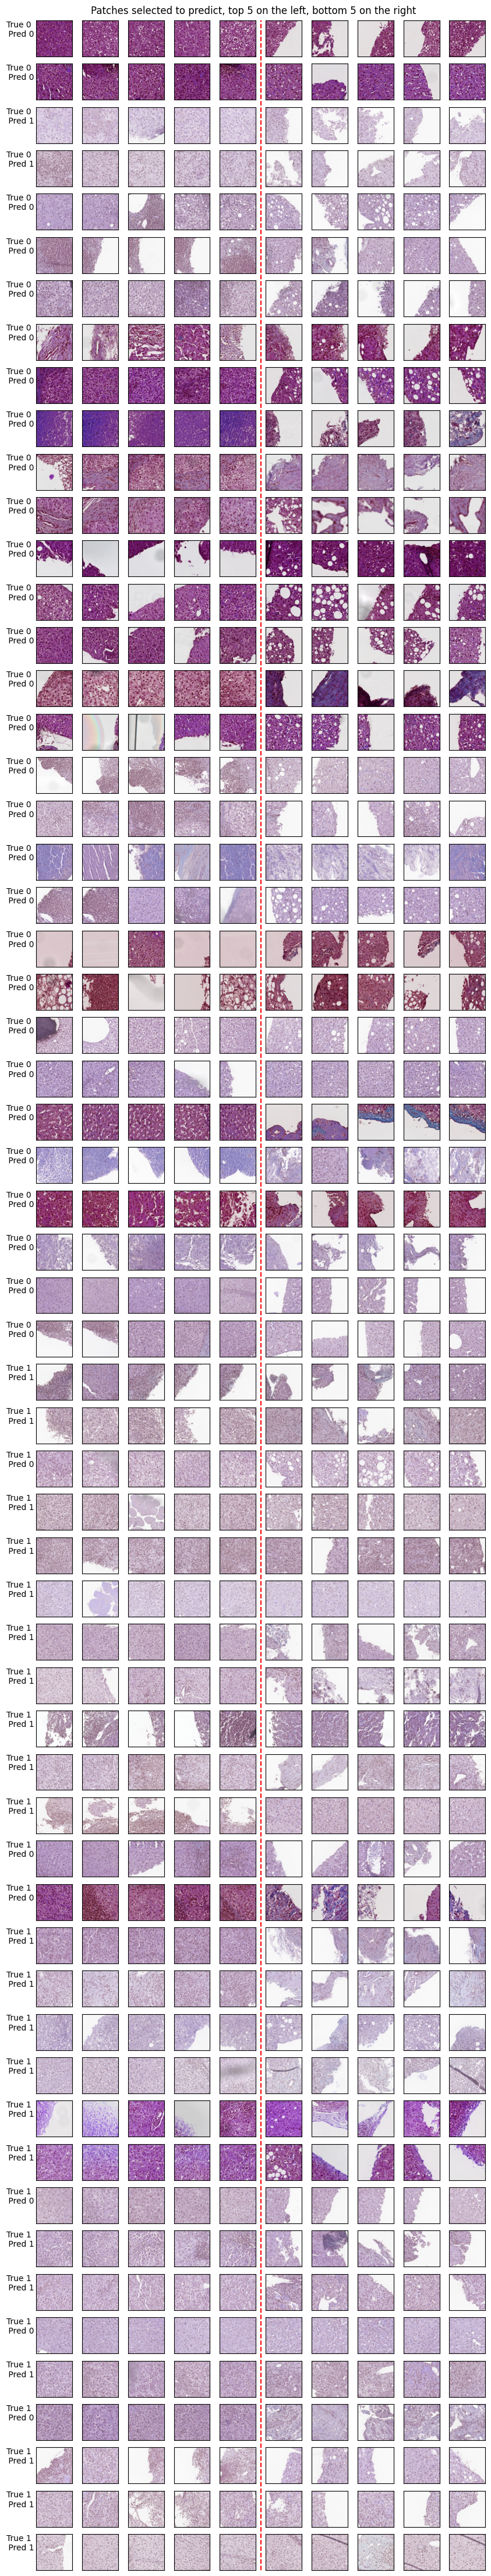

In [299]:
# figure
n_col=model_test.extreme_layer.n_top+model_test.extreme_layer.n_bottom
fig,axs=plt.subplots(nrows=len(patient_patches), ncols=n_col, figsize=(n_col,n_col*5))
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.975, wspace=None, hspace=None)
i=0
for key in list(patient_patches.keys()):
    patch_list=patient_patches[key]
    for j in range(n_col):
        ax=axs[i,j]
        ax.imshow(load_image(patch_list[j]))
        if j==0:
            ax.set_ylabel(f'True {labels[labels["patient_id"]==key]["label"].iloc[0]} \n Pred {patient_pred[key]["pred"]}', rotation=0, labelpad=n_col*2)
        
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    i+=1
line=plt.Line2D((.5125,.5125),(.1,.975), linestyle='--', color='red')
fig.add_artist(line)
fig.suptitle('Patches selected to predict, top 5 on the left, bottom 5 on the right')